# Laboratorio Regresión Lineal Multiple, regresión polinomica y  calculo por la ecuación de la normal

---



# Regresión Lineal Multiple

---



La regresión lineal múltiple consiste en modelar una variable dependiente como combinación lineal de varias variables independientes. Este modelo permite evaluar cómo cada variable influye en el resultado final y se ajusta utilizando el descenso de gradiente para minimizar el error cuadrático medio.

In [159]:
# utilizado para manejos de directorios y rutas
import os

# Computacion vectorial y cientifica para python
import numpy as np
import pandas as pd

# Librerias para graficación (trazado de gráficos)
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D  # Necesario para graficar superficies 3D

# llama a matplotlib a embeber graficas dentro de los cuadernillos
%matplotlib inline

In [ ]:
#from google.colab import drive
#drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cargar datos
#data = pd.read_csv('/content/drive/MyDrive/sis420/machine_learning/datasets/PRSA_data_2010_1_1_2014_12_31.csv')
data = pd.read_csv('PRSA_data_2010_1_1_2014_12_31.csv')

data = data[['year', 'month', 'day', 'hour', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']]
data = data.dropna(subset=['pm2.5'])
data =data.head(10100)
X = data[['year', 'month', 'day', 'hour', 'DEWP', 'TEMP',
          'PRES', 'Iws', 'Is', 'Ir']]
y = data['pm2.5']
m = y.size
print(m)

10100


Normalización de valores

Antes de entrenar el modelo, es necesario normalizar las variables de entrada para que todas estén en un rango similar. De esta forma se evitan problemas de convergencia, ya que los parámetros se actualizan de manera más equilibrada y el descenso de gradiente no se ve afectado por diferencias de escala entre las variables

In [162]:
def  featureNormalize(X):

    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [163]:
# llama featureNormalize con los datos cargados
X_norm, mu, sigma = featureNormalize(X)

print(X)
print('Media calculada:', mu)
print('Desviación estandar calculada:', sigma)
print(X_norm)

       year  month  day  hour  DEWP  TEMP    PRES    Iws  Is  Ir
24     2010      1    2     0   -16  -4.0  1020.0   1.79   0   0
25     2010      1    2     1   -15  -4.0  1020.0   2.68   0   0
26     2010      1    2     2   -11  -5.0  1021.0   3.57   0   0
27     2010      1    2     3    -7  -5.0  1022.0   5.36   1   0
28     2010      1    2     4    -7  -5.0  1022.0   6.25   2   0
...     ...    ...  ...   ...   ...   ...     ...    ...  ..  ..
10957  2011      4    2    13   -12  13.0  1029.0   8.50   0   0
10958  2011      4    2    14   -13  13.0  1028.0  11.63   0   0
10959  2011      4    2    15   -12  13.0  1026.0  13.42   0   0
10960  2011      4    2    16   -12  14.0  1026.0  15.21   0   0
10961  2011      4    2    17   -10  14.0  1025.0   3.13   0   0

[10100 rows x 10 columns]
Media calculada: year     2010.198911
month       5.603960
day        15.534059
hour       11.497129
DEWP       -1.712871
TEMP        9.106832
PRES     1018.353317
Iws        31.820803
Is      

Se añade el temino de interseccion a X_norm:

En los modelos de regresión se incluye un término adicional llamado sesgo o intercepto. Este valor permite que la recta o hiperplano resultante no esté obligado a pasar por el origen, lo que mejora la capacidad de ajuste del modelo a los datos reales

In [164]:
# Añade el termino de interseccion a X
# (Columna de unos para X0)
X = np.concatenate([np.ones((m, 1)), X_norm], axis=1)

In [165]:
print(X)

[[ 1.         -0.49829768 -1.27487224 ... -0.50176723 -0.08896247
  -0.13206234]
 [ 1.         -0.49829768 -1.27487224 ... -0.48689673 -0.08896247
  -0.13206234]
 [ 1.         -0.49829768 -1.27487224 ... -0.47202624 -0.08896247
  -0.13206234]
 ...
 [ 1.          2.00683253 -0.44414904 ... -0.30744832 -0.08896247
  -0.13206234]
 [ 1.          2.00683253 -0.44414904 ... -0.27754025 -0.08896247
  -0.13206234]
 [ 1.          2.00683253 -0.44414904 ... -0.47937794 -0.08896247
  -0.13206234]]


Descenso por el gradiente

El descenso de gradiente es el algoritmo de optimización que ajusta los parámetros del modelo de manera iterativa. En cada paso se calcula la dirección en la que el error disminuye más rápidamente y se actualizan los valores de los parámetros en esa dirección. El proceso se repite hasta alcanzar un valor mínimo de la función de costo

In [166]:
def computeCostMulti(X, y, theta):
    # Inicializa algunos valores utiles
    m = y.shape[0] # numero de ejemplos de entrenamiento

    J = 0

    # h = np.dot(X, theta)

    J = (1/(2 * m)) * np.sum(np.square(np.dot(X, theta) - y))

    return J

In [167]:
def gradientDescentMulti(X, y, theta, alpha, num_iters):

    # Inicializa algunos valores
    m = y.shape[0] # numero de ejemplos de entrenamiento

    # realiza una copia de theta, el cual será acutalizada por el descenso por el gradiente

    theta = theta.copy()

    J_history = []

    for i in range(num_iters):
        theta = theta - (alpha / m) * (np.dot(X, theta) - y).dot(X)
        J_history.append(computeCostMulti(X, y, theta))

    return theta, J_history

Seleccionar coeficientes de aprendizaje

La tasa de aprendizaje es un parámetro clave del descenso de gradiente. Si es demasiado alta, el algoritmo puede no converger; si es demasiado baja, el ajuste será muy lento. En este paso se prueban diferentes valores para observar cómo afectan la rapidez y estabilidad de la convergencia del modelo

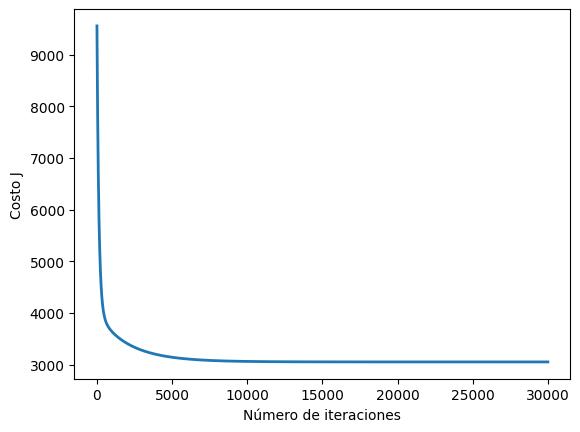

Real: 42.00 | Predicho: 48.55
Real: 51.00 | Predicho: 57.73
Real: 60.00 | Predicho: 107.11
Real: 65.00 | Predicho: 114.99
Real: 61.00 | Predicho: 118.77
Real: 56.00 | Predicho: 126.84
Real: 69.00 | Predicho: 100.66
Real: 76.00 | Predicho: 109.02
Real: 58.00 | Predicho: 123.52
Real: 64.00 | Predicho: 131.15
Real: 79.00 | Predicho: 137.92
Real: 100.00 | Predicho: 139.20
Real: 128.00 | Predicho: 148.03
Real: 110.00 | Predicho: 150.61
Real: 116.00 | Predicho: 110.03
Real: 97.00 | Predicho: 96.09
Real: 99.00 | Predicho: 86.73
Real: 107.00 | Predicho: 79.28
Real: 101.00 | Predicho: 57.82
Real: 94.00 | Predicho: 34.30
Real: 70.00 | Predicho: -2.22
Real: 49.00 | Predicho: -0.85
Real: 59.00 | Predicho: 4.05
Real: 60.00 | Predicho: 6.72
Real: 51.00 | Predicho: 19.99
Real: 55.00 | Predicho: 28.06
Real: 73.00 | Predicho: 30.73
Real: 70.00 | Predicho: 47.00
Real: 67.00 | Predicho: 52.81
Real: 64.00 | Predicho: 94.72
Real: 75.00 | Predicho: 93.88
Real: 87.00 | Predicho: 102.52
Real: 96.00 | Predicho

In [168]:
# Elegir algun valor para alpha (probar varias alternativas)
alpha = 0.002  # también puedes probar alpha = 0.003
num_iters = 30000

# Asegurar que X tiene la columna de 1s (bias)
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

# inicializa theta y ejecuta el descenso por el gradiente
theta = np.zeros(X.shape[1])  # ahora coincide con el número de columnas
theta, J_history = gradientDescentMulti(X, y, theta, alpha, num_iters)

pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Número de iteraciones')
pyplot.ylabel('Costo J')
pyplot.show()

# === ESTIMAR para los últimos 100 valores de tu dataset ===
X_last = X[-100:]
y_last = y[-100:]
y_pred_last = X_last.dot(theta)

# Mostrar comparaciones de los primeros 100
for real, pred in zip(y_last[:100], y_pred_last[:100]):
    print(f"Real: {real:.2f} | Predicho: {pred:.2f}")

# Calcular MSE manualmente
errors = y_last - y_pred_last
mse = np.mean(errors ** 2)

# Calcular R² manualmente
ss_res = np.sum(errors ** 2)                              # suma de residuos al cuadrado
ss_tot = np.sum((y_last - np.mean(y_last)) ** 2)          # suma total de cuadrados
r2 = 1 - (ss_res / ss_tot)

print("MSE últimos 100:", mse)
print("R² últimos 100:", r2)

#Ecuación de la normal

---

La ecuación de la normal ofrece una solución directa al problema de regresión lineal múltiple sin necesidad de iteraciones. Mediante operaciones matriciales se obtiene un conjunto de parámetros que minimizan el error cuadrático medio. Aunque este método evita el descenso de gradiente, puede ser computacionalmente costoso en conjuntos de datos muy grandes

In [169]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/sis420/machine_learning/datasets/PRSA_data_2010_1_1_2014_12_31.csv')

data = data[['year', 'month', 'day', 'hour', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']]
data = data.dropna(subset=['pm2.5'])
X = data[['year', 'month', 'day', 'hour', 'DEWP', 'TEMP',
          'PRES', 'Iws', 'Is', 'Ir']]
y = data['pm2.5']
m = y.size
print(m)
X = np.concatenate([np.ones((m, 1)), X], axis=1)

41757


In [170]:
def normalEqn(X, y):

    theta = np.zeros(X.shape[1])

    theta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),y)

    return theta

In [171]:
# Calcula los parametros con la ecuación de la normal
theta = normalEqn(X, y);

# Muestra los resultados optenidos a partir de la aplicación de la ecuación de la normal
print('Theta calculado a partir de la ecuación de la normal: {:s}'.format(str(theta)));

# Estimar pm2.5 para los últimos 100 registros
X_array = X[-100:]          # últimos 100 registros
y_pred_last = np.dot(X_array, theta)

# Mostrar primeras 10 predicciones
for i in range(10):
    print(f"Real: {y.values[-100:][i]:.2f} | Predicho: {y_pred_last[i]:.2f}")

Theta calculado a partir de la ecuación de la normal: [-37.07815439   0.87383715  -1.4691313    0.78349189   1.6422183
   4.75278281  -6.61575085  -1.53753555  -0.25076471  -2.79595532
  -7.34534925]
Real: 349.00 | Predicho: 157.86
Real: 327.00 | Predicho: 165.90
Real: 348.00 | Predicho: 178.36
Real: 363.00 | Predicho: 176.89
Real: 385.00 | Predicho: 146.41
Real: 393.00 | Predicho: 137.58
Real: 388.00 | Predicho: 137.03
Real: 444.00 | Predicho: 134.67
Real: 334.00 | Predicho: 143.68
Real: 284.00 | Predicho: 144.87


#Regresión Polinómica

---



La regresión polinómica amplía el modelo lineal al incluir potencias de las variables originales. Esto permite capturar relaciones no lineales y obtener un ajuste más flexible cuando los datos no siguen un patrón lineal simple. El procedimiento de entrenamiento es similar al de la regresión múltiple, pero considerando estos nuevos términos en la matriz de entrada

In [172]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/sis420/machine_learning/datasets/PRSA_data_2010_1_1_2014_12_31.csv')

data = data[['year', 'month', 'day', 'hour', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']]
data = data.dropna(subset=['pm2.5'])
X = data[['year', 'month', 'day', 'hour', 'DEWP', 'TEMP',
          'PRES', 'Iws', 'Is', 'Ir']]
y = data['pm2.5']
m = y.size
print(m)

41757


In [173]:
X = np.concatenate([X, X*X], axis=1)  # ahora cada feature tiene su cuadrado


In [174]:
print(X)

[[2.01000000e+03 1.00000000e+00 2.00000000e+00 ... 3.20410000e+00
  0.00000000e+00 0.00000000e+00]
 [2.01000000e+03 1.00000000e+00 2.00000000e+00 ... 7.18240000e+00
  0.00000000e+00 0.00000000e+00]
 [2.01000000e+03 1.00000000e+00 2.00000000e+00 ... 1.27449000e+01
  0.00000000e+00 0.00000000e+00]
 ...
 [2.01400000e+03 1.20000000e+01 3.10000000e+01 ... 5.89032900e+04
  0.00000000e+00 0.00000000e+00]
 [2.01400000e+03 1.20000000e+01 3.10000000e+01 ... 6.08707584e+04
  0.00000000e+00 0.00000000e+00]
 [2.01400000e+03 1.20000000e+01 3.10000000e+01 ... 6.24250225e+04
  0.00000000e+00 0.00000000e+00]]


In [175]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [176]:
# llama featureNormalize con los datos cargados
X_norm, mu, sigma = featureNormalize(X)

#print(X)
#print('Media calculada:', mu)
#print('Desviación estandar calculada:', sigma)
#print(X_norm)

In [177]:
print(X_norm)

[[-1.44335511 -1.59626706 -1.55775043 ... -0.21233619 -0.04818368
  -0.07460732]
 [-1.44335511 -1.59626706 -1.55775043 ... -0.21205724 -0.04818368
  -0.07460732]
 [-1.44335511 -1.59626706 -1.55775043 ... -0.21166721 -0.04818368
  -0.07460732]
 ...
 [ 1.38291355  1.58830091  1.74316783 ...  3.91764043 -0.04818368
  -0.07460732]
 [ 1.38291355  1.58830091  1.74316783 ...  4.05559606 -0.04818368
  -0.07460732]
 [ 1.38291355  1.58830091  1.74316783 ...  4.16457849 -0.04818368
  -0.07460732]]


In [178]:
# Añade el termino de interseccion a X
# (Columna de unos para X0)
#X_norm = np.concatenate([X_norm, X_norm * X_norm], axis=1)
X = np.concatenate([np.ones((m, 1)), X_norm], axis=1)

Descenso por el gradiente

De la misma forma que en la regresión múltiple, se aplica el descenso de gradiente para ajustar los parámetros del modelo polinómico. El error se va reduciendo con cada iteración, logrando que la curva ajustada se acerque lo más posible a los valores reales observados en el conjunto de datos

In [179]:
def computeCostMulti(X, y, theta):
    # Inicializa algunos valores utiles
    m = y.shape[0] # numero de ejemplos de entrenamiento

    J = 0

    h = np.dot(X, theta)

    J = (1/(2 * m)) * np.sum(np.square(np.dot(X, theta) - y))

    return J


In [180]:
def gradientDescentMulti(X, y, theta, alpha, num_iters):

    # Inicializa algunos valores
    m = y.shape[0] # numero de ejemplos de entrenamiento

    # realiza una copia de theta, el cual será acutalizada por el descenso por el gradiente
    theta = theta.copy()

    J_history = []

    for i in range(num_iters):
        theta = theta - (alpha / m) * (np.dot(X, theta) - y).dot(X)
        J_history.append(computeCostMulti(X, y, theta))

    return theta, J_history

theta calculado por el descenso por el gradiente: [ 98.61321455   0.14383242 -52.77434309   9.84774416  18.15143164
  71.12807789 -69.87566216  -7.81892337 -24.13811205  -3.66947757
 -16.81760551   0.19265488  46.51043701  -3.73308137  -8.09931383
 -12.24674174  -2.33520281  -9.62144708  15.55783046   1.02030681
   7.94740147]
Real: 349.00 | Predicho: 162.87
Real: 327.00 | Predicho: 168.74
Real: 348.00 | Predicho: 182.49
Real: 363.00 | Predicho: 176.18
Real: 385.00 | Predicho: 147.72
Real: 393.00 | Predicho: 143.00
Real: 388.00 | Predicho: 145.20
Real: 444.00 | Predicho: 141.73
Real: 334.00 | Predicho: 149.92
Real: 284.00 | Predicho: 151.27


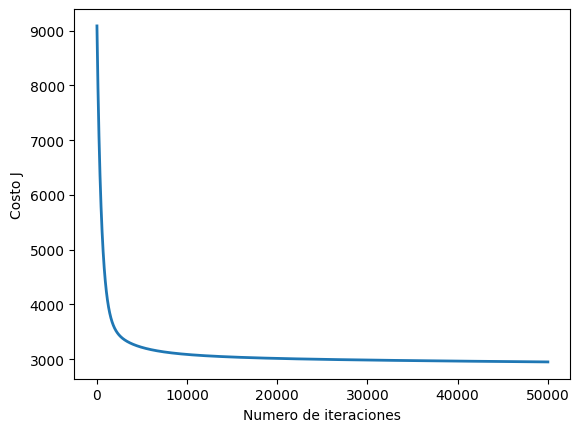

In [181]:
# Elegir algun valor para alpha (probar varias alternativas)
alpha = 0.001
num_iters = 50000

# inicializa theta y ejecuta el descenso por el gradiente
theta = np.zeros(X.shape[1])
theta, J_history = gradientDescentMulti(X, y, theta, alpha, num_iters)

# Grafica la convergencia del costo
pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Numero de iteraciones')
pyplot.ylabel('Costo J')

# Muestra los resultados del descenso por el gradiente
print('theta calculado por el descenso por el gradiente: {:s}'.format(str(theta)))


# Estimar pm2.5 para los últimos 100 registros
X_array = X[-100:]          # últimos 100 registros
y_pred_last = np.dot(X_array, theta)

# Mostrar primeras 10 predicciones
for i in range(10):
    print(f"Real: {y.values[-100:][i]:.2f} | Predicho: {y_pred_last[i]:.2f}")

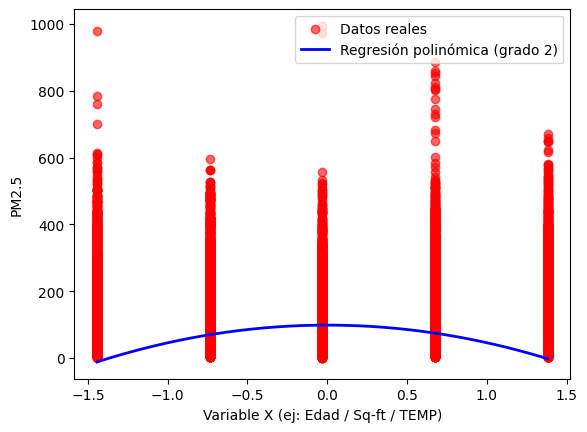

In [182]:
def plotPolyDataset(X, y, theta, degree=2):
    """
    Grafica los puntos reales del dataset y la curva polinómica ajustada
    sobre la primera característica de X.
    """
    # Tomamos la primera variable de X (excluyendo el 1 de bias si lo tienes)
    x_feature = X[:, 1]

    pyplot.scatter(x_feature, y, color='red', label="Datos reales", alpha=0.6)

    # Generar valores ordenados para la curva
    x_plot = np.linspace(min(x_feature), max(x_feature), 300)

    # Construir matriz polinómica para x_plot
    X_poly = np.ones((len(x_plot), 1))
    for d in range(1, degree + 1):
        X_poly = np.concatenate([X_poly, (x_plot ** d).reshape(-1, 1)], axis=1)

    # Calcular predicciones con theta
    y_plot = np.dot(X_poly, theta[:degree+1])

    # Dibujar la curva ajustada
    pyplot.plot(x_plot, y_plot, 'b-', linewidth=2, label=f'Regresión polinómica (grado {degree})')

    pyplot.xlabel("Variable X (ej: Edad / Sq-ft / TEMP)")
    pyplot.ylabel("PM2.5")
    pyplot.legend()
    pyplot.show()

# Uso con tu dataset (ejemplo para grado 2)
plotPolyDataset(X, y, theta, degree=2)


Ecuación de la Normal

---



También es posible aplicar la ecuación de la normal al caso polinómico. El principio es el mismo: calcular de forma matricial los parámetros que minimizan el error. Este método evita las iteraciones, pero al incluir muchos términos polinómicos puede volverse pesado en cuanto a cálculos y memoria

In [183]:
data = pd.read_csv('/content/drive/MyDrive/sis420/machine_learning/datasets/PRSA_data_2010_1_1_2014_12_31.csv')
data = data[['year', 'month', 'day', 'hour', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']]
data = data.dropna(subset=['pm2.5'])

X = data[['year', 'month', 'day', 'hour', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']].values
y = data['pm2.5'].values
m = y.size

X_original = X.copy()
X = np.concatenate([X, X * X], axis=1)
X = np.concatenate([np.ones((m, 1)), X], axis=1)

In [184]:
def normalEqn(X, y):

    theta = np.zeros(X.shape[1])

    theta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),y)

    return theta

In [185]:
# Calcula los parametros con la ecuación de la normal
theta = normalEqn(X, y);

# Muestra los resultados optenidos a partir de la aplicación de la ecuación de la normal
print('Theta calculado a partir de la ecuación de la normal: {:s}'.format(str(theta)));

# Estimar pm2.5 para los últimos 100 registros
X_array = X[-100:]          # últimos 100 registros
y_pred_last = np.dot(X_array, theta)

# Mostrar primeras 10 predicciones
for i in range(100):
    print(f"Real: {y[-100:][i]:.2f} | Predicho: {y_pred_last[i]:.2f}")

Theta calculado a partir de la ecuación de la normal: [ 5.37655777e+06 -5.43319710e+03 -7.42193484e+01  1.66317036e+00
  1.03664328e+00  5.85911076e+00 -3.20096992e+00  1.79568410e+02
 -3.92437478e-01 -6.43341899e+00 -1.09968339e+01  1.35001983e+00
  5.29561446e+00 -3.38104278e-02 -6.25504739e-03 -5.88201032e-02
 -1.61974602e-02 -8.92712172e-02  9.47290767e-04  1.18712875e-01
  2.63204287e-01]
Real: 349.00 | Predicho: 168.36
Real: 327.00 | Predicho: 171.88
Real: 348.00 | Predicho: 189.44
Real: 363.00 | Predicho: 179.31
Real: 385.00 | Predicho: 161.43
Real: 393.00 | Predicho: 161.61
Real: 388.00 | Predicho: 165.88
Real: 444.00 | Predicho: 162.00
Real: 334.00 | Predicho: 167.89
Real: 284.00 | Predicho: 168.20
Real: 264.00 | Predicho: 164.93
Real: 221.00 | Predicho: 167.84
Real: 160.00 | Predicho: 174.64
Real: 160.00 | Predicho: 175.18
Real: 92.00 | Predicho: 146.19
Real: 59.00 | Predicho: 130.96
Real: 69.00 | Predicho: 129.16
Real: 48.00 | Predicho: 119.99
Real: 32.00 | Predicho: 114.70
